# Bed simulation

In [7]:
"""
Bed counter-factual Simulation

Covers:

- Resources: Resource
- Waiting for other processes

Scenario:
    We are trying to assess if using a non-greedy approach would
    reduce total moratality in ICU

- A patient arrives at the ICU - the logic!
beds = simulated_beds + remaining_beds

# If there are no beds in the correct specialty area irl
if remaining_beds=0:
    boarded = True
else:
    boarded = False
# If there are no beds in the simulation for the correct specialty area
if beds > 0 | predicted_board:
    simulation_boarded = True
else:
    simulation_boarded = False

if simulation_boarded & boarded:
    wait for a bit
    leave
if simulation_boarded & not boarded:
    increment simulated beds
    wait for a bit
    leave
if not simulation_boarded & boarded:
    decrement simulation beds
    wait for a bit
if not simulation_boarded & not boarded:  # repeated for readability...
    wait for a bit
    leave
"""
import itertools
import random
import pandas as pd

import simpy


RANDOM_SEED = 42
T_INTER = [5, 20]        # Create a patient every [min, max] minutes
SIM_TIME = 60*12*7          # Simulation time in minutes
NUMBER_OF_BEDS = 200

df = pd.read_csv('data.csv')
df['predicted_boarded'] = False
patients = df.to_dict(orient='records')

# Toy data
#patients = [{'transfers.subject_id': 1, 'icustay_los_total': 50, 'remaining_beds': 6, 'predicted_boarded': False},
#            {'transfers.subject_id': 2, 'icustay_los_total': 30, 'remaining_beds': 6, 'predicted_boarded': False}]


global simulated_beds
simulated_beds = 10
mortalityStore = []
agreementStore = []

def patient(env, beds_correct, **p):
    global simulated_beds
    print('%s arriving at ICU at %.1f' % (p['transfers.subject_id'], env.now))

    beds = simulated_beds + p['remaining_beds']
    if p['remaining_beds'] == 0:
        boarded = True
    else:
        boarded = False

    # If there are no beds in the simulation for the correct specialty area
    if p['predicted_boarded']: # beds < 0 | 
        simulation_boarded = True
        print("Decision made")
        print(beds)
    else:
        simulation_boarded = False

    if simulation_boarded & boarded:
        print("Agreed boarding")
        agreementStore.append("Agreed boarding")
        mortalityStore.append(p['days_survived'])
        with beds_correct.request() as req:
            start = env.now
            # Request one of the beds
            yield req
            # Stay in a bed for a bit
            yield env.timeout(p['icustay_los_total'])

            print('%s left ward in %.1f minutes.' % (p['transfers.subject_id'], env.now - start))
    elif simulation_boarded & (not boarded):
        print("Disagree boarding")
        agreementStore.append("Disagree boarding")
        mortalityStore.append(p['days_survived'])
        with beds_correct.request() as req:
            start = env.now
            simulated_beds += 1
            # Request one of the beds
            yield req
            # Stay in a bed for a bit
            yield env.timeout(p['icustay_los_total'])
            #simulated_beds -= 1

            print('%s left ward in %.1f minutes.' % (p['transfers.subject_id'], env.now - start))
    elif (not simulation_boarded) and boarded:
        print("Disagree not boarding")
        agreementStore.append("Disagree not boarding")
        mortalityStore.append(p['days_survived'])
        with beds_correct.request() as req:
            start = env.now
            simulated_beds -= 1
            # Request one of the beds
            yield req
            # Stay in a bed for a bit
            yield env.timeout(p['icustay_los_total'])
            #simulated_beds += 1

            print('%s left ward in %.1f minutes.' % (p['transfers.subject_id'], env.now - start))
    elif simulation_boarded and boarded:
        print("Agreed not boarding")
        agreementStore.append("Agreed not boarding")
        mortalityStore.append(p['days_survived'])
        with beds_correct.request() as req:
            start = env.now
            # Request one of the beds
            yield req
            # Stay in a bed for a bit
            yield env.timeout(p['icustay_los_total'])

            print('%s left ward in %.1f minutes.' % (p['transfers.subject_id'], env.now - start))




def patient_generator(env, beds_correct, patients):
    """Generate new patient that arrive at the ICU."""
    for i in itertools.count():
        yield env.timeout(random.randint(*T_INTER))
        p = random.sample(patients, 1)[0]
        #print_name = 'Simulation id {}'.format(i) #, Data id  %s' % (i, p['transfers.subject_id'])
        env.process(patient(env, beds_correct, **p))


# Create environment and start processes
env = simpy.Environment()
beds_correct = simpy.Resource(env, NUMBER_OF_BEDS)
#bed_boarded = simpy.Resource(env, 1, NUMBER_OF_BEDS)
env.process(patient_generator(env, beds_correct, patients)) #beds_boarded,

# Execute!
env.run(until=SIM_TIME)

print(simulated_beds)




/Users/andrevauvelle/anaconda3/envs/flask/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


25578 arriving at ICU at 15.0
6652 arriving at ICU at 26.0
8296 arriving at ICU at 34.0
67740 arriving at ICU at 52.0
6429 arriving at ICU at 60.0
6830 arriving at ICU at 66.0
6615 arriving at ICU at 75.0
15858 arriving at ICU at 87.0
15648 arriving at ICU at 95.0
77729 arriving at ICU at 110.0
Disagree not boarding
18815 arriving at ICU at 120.0
77729 left ward in 16.6 minutes.
9912 arriving at ICU at 136.0
69264 arriving at ICU at 141.0
94574 arriving at ICU at 150.0
54353 arriving at ICU at 157.0
29544 arriving at ICU at 164.0
99424 arriving at ICU at 170.0
5100 arriving at ICU at 176.0
9846 arriving at ICU at 184.0
26377 arriving at ICU at 189.0
1923 arriving at ICU at 206.0
46672 arriving at ICU at 218.0
13303 arriving at ICU at 223.0
Disagree not boarding
31881 arriving at ICU at 229.0
97060 arriving at ICU at 242.0
31500 arriving at ICU at 256.0
23451 arriving at ICU at 264.0
13303 left ward in 56.9 minutes.
4016 arriving at ICU at 283.0
49557 arriving at ICU at 290.0
73473 arri

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


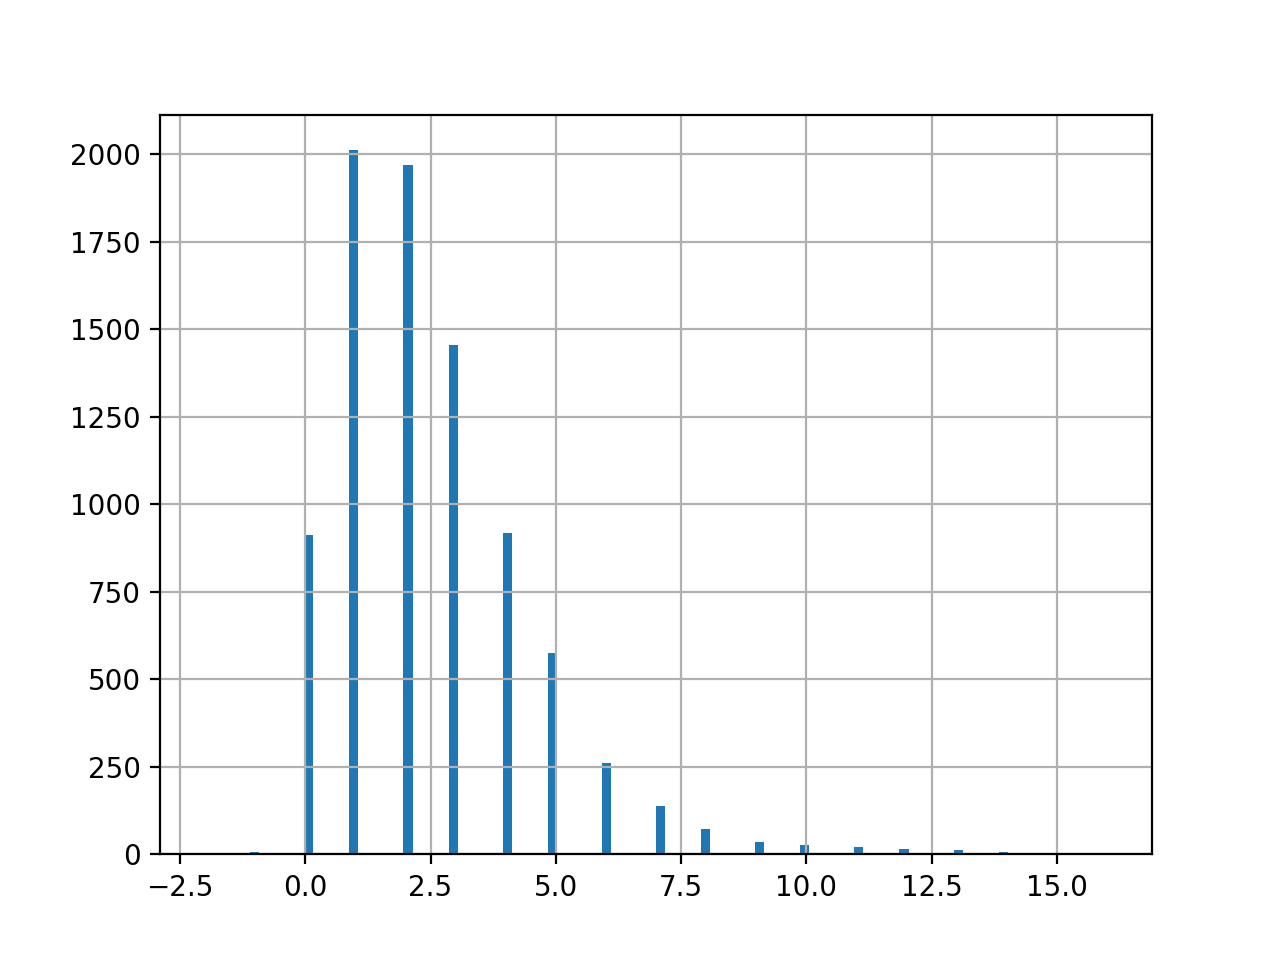

In [9]:
df['remaining_beds'].hist(bins = 100)